In [1]:
import os, glob, platform
import numpy as np
import numpy.matlib
import pickle
import pandas as pd
import pathlib
import matplotlib
import matplotlib.pyplot as plt
import mne
mne.__version__
from mne.viz import plot_alignment, snapshot_brain_montage
import shutil
from mne.datasets import eegbci
from sklearn.model_selection import train_test_split

# from mne_bids import write_raw_bids, BIDSPath, print_dir_tree, make_dataset_description
# from mne_bids.stats import count_events
import sys


In [2]:
path_utils = '/decoding_toolbox_py/helper_funcs' 
sys.path.append(path_utils)

In [3]:
''' VARIABLES '''

dataset = 'eeg'

amount_of_subjects = 1 # Change the range so the process is faster
if amount_of_subjects > 26: amount_of_subjects = 26
subjs_list = ['s{:02d}'.format(i) for i in range(1, amount_of_subjects+1) if i != 6 ] 
print(subjs_list)
nSubj = len(subjs_list)

numC = 8

angles = [i * 180./numC for i in range(numC)]

x_labels = np.array(angles)

resample = False # speeds up the procees but showing worse results overall
if resample: resample_frequency = 20 # in Hz, original freq is 500Hz

cfg_stim = dict()
cfg_stim['kappa'] = 4
cfg_stim['NumC'] = numC
cfg_stim['Tuning'] = 'vonmises'
# cfg_stim['Tuning'] = 'halfRectCos'
cfg_stim['offset'] = 0

cfg_train = dict()
cfg_train['gamma'] = 0.1
cfg_train['demean'] = True
cfg_train['returnPattern'] = True

cfg_test = dict()
cfg_test['demean'] = 'traindata'

['s01']


In [4]:
from toolbox.methods import read_data
all_epochs, all_rawdata = read_data (task = 'main', resample=False,subjs_list=subjs_list, resample_frequency=10, return_epochs =True)

In [5]:
all_epochs[0].ch_names[25]

'Eye'

In [6]:
print(len(all_rawdata))
all_rawdata[0]['metadata'].columns

1


Index(['index', 'subj', 'nblock', 'ntrial', 'nrep', 'trial_type', 'cond-1',
       'cond', 'rDV', 'DV', 'resp', 'deci-2', 'deci-1', 'deci', 'corr-1',
       'r_map', 'correct', 'confi', 'RT', 'd1', 'conf_lvl', 'correct-1', 'd2',
       'd3', 'd4', 'd5', 'd6', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'confi-1',
       'conf_lvl-1'],
      dtype='object')

In [7]:
# all_rawdata[0]['metadata'][['deci','deci-1']].head(50)

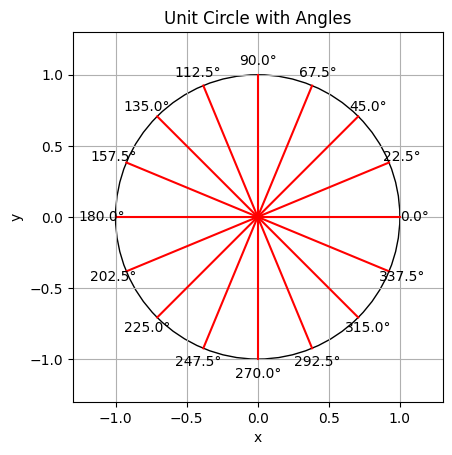

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Generate angles from 0 to 360 degrees at 22.5-degree intervals
angles = np.arange(0, 360, 22.5)

# Convert angles from degrees to radians
angles_rad = np.radians(angles)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot unit circle
unit_circle = plt.Circle((0, 0), 1, edgecolor='black', facecolor='none')
ax.add_artist(unit_circle)

# Plot angles on the unit circle and add labels
for angle_rad, angle_deg in zip(angles_rad, angles):
    x = np.cos(angle_rad)
    y = np.sin(angle_rad)
    ax.plot([0, x], [0, y], color='red')
    label_x = 1.1 * np.cos(angle_rad)
    label_y = 1.1 * np.sin(angle_rad)
    ax.text(label_x, label_y, f'{angle_deg}°', ha='center', va='center')

# Set plot limits and aspect ratio
ax.set_xlim([-1.3, 1.3])
ax.set_ylim([-1.3, 1.3])
ax.set_aspect('equal')

# Add gridlines and labels
ax.grid(True)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Unit Circle with Angles')

# Show the plot
plt.show()


In [9]:
import numpy as np

all_rawdata[0]['metadata'][['o1', 'o2', 'o3', 'o4', 'o5', 'o6']] *= 180 / np.pi


In [10]:
all_rawdata[0]['metadata'][['o1','o2','o3','o4','o5','o6','deci']]

,o1,o2,o3,o4,o5,o6,deci
883,154.526717,40.966482,109.033868,90.298149,69.557076,88.751162,0
896,154.526717,40.966482,109.033868,90.298149,69.557076,88.751162,0
909,154.526717,40.966482,109.033868,90.298149,69.557076,88.751162,0
922,95.970431,154.354830,109.434939,107.486882,73.052119,38.502764,1
935,95.970431,154.354830,109.434939,107.486882,73.052119,38.502764,1
...,...,...,...,...,...,...,...
4240,172.574888,98.720628,17.188734,155.271562,149.198210,172.460296,0
4253,172.574888,98.720628,17.188734,155.271562,149.198210,172.460296,0
4266,172.574888,98.720628,17.188734,155.271562,149.198210,172.460296,0
4279,147.307449,69.156006,39.018426,109.434939,137.452575,82.162148,1


In [14]:
from toolbox.methods import ML_train
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from catboost import CatBoostClassifier

X = all_rawdata[0]['metadata'][['o1', 'o2', 'o3', 'o4', 'o5', 'o6']]
y = all_rawdata[0]['metadata']['deci']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf = RandomForestClassifier()
clf = CatBoostClassifier(task_type='GPU', verbose=False)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
acc = accuracy_score(y_test, y_pred)
print('accuracy score: ', acc)
print(np.unique(y_test, return_counts=True))
print(np.unique(y_pred, return_counts=True))

feature_importances = clf.feature_importances_

feature_names = X_train.columns
sorted_indices = np.argsort(feature_importances)[::-1]

for i, idx in enumerate(sorted_indices):
    print(f"{i+1}. {feature_names[idx]}: {feature_importances[idx]}")

              precision    recall  f1-score   support

           0       0.83      0.67      0.74        15
           1       0.87      0.94      0.90        35

    accuracy                           0.86        50
   macro avg       0.85      0.80      0.82        50
weighted avg       0.86      0.86      0.86        50

accuracy score:  0.86
(array([0, 1]), array([15, 35]))
(array([0, 1]), array([12, 38]))
1. o1: 22.90772983108301
2. o6: 21.892814222046514
3. o5: 18.438929193848836
4. o2: 15.326758563705782
5. o4: 12.690240420267806
6. o3: 8.743527769048068


In [12]:
multivariate arima below, ignore for now

SyntaxError: invalid syntax (2930366199.py, line 1)

In [ ]:
use_timepoint = False
reshape = False
timepoint = 10
X = all_rawdata[0]['epoch_dat']
print(X.shape)
# X = X.reshape(X.shape[0],-1)
y = all_rawdata[0]['metadata']['deci']
y = np.array(y)
print(y.shape)

for i in range(1, nSubj):

    X_temp = all_rawdata[i]['epoch_dat']
    # X_temp = X_temp.reshape((X_temp.shape[0]*X_temp.shape[1], X_temp.shape[2]))
    # shapes[i+1] = shapes[i] + X_temp.shape[0]
    y_temp = all_rawdata[i]['metadata']['deci']
    # y_temp = np.tile(y_temp, numC)
    # X = np.vstack((X, X_temp))
    X = np.concatenate((X, X_temp))
    y = np.concatenate((y, y_temp))

print(X.shape, y.shape)
if use_timepoint: 
    X = X[:,:,timepoint]
else:
    if reshape:
        X = X.reshape(X.shape[0], -1)
print(X.shape, y.shape)
X = np.einsum('ijk->ikj',X)
print(X.shape, y.shape)
X = np.delete(X, 25, axis=2)
#X = X[:,:,25]
print(X.shape, y.shape)
X = X.reshape(X.shape[0], -1)
print(X.shape, y.shape)


(250, 32, 2876)
(250,)
(250, 32, 2876) (250,)
(250, 32, 2876) (250,)
(250, 2876, 32) (250,)
(250, 2876, 31) (250,)
(250, 89156) (250,)


In [ ]:
# index_0 = [y==0][0]
# index_1 = [y==1][0]
# print(index_0.shape)
# print(index_1.shape)
# index_1[117:250] = False 
# print(y[index_1].shape)
# X[index_0].shape
# index = index_0 + index_1
# y = y[index]
# X = X[index,:,:]
# print(X.shape, y.shape)
# X = np.delete(X, 25, axis=2)
# print(X.shape, y.shape)


In [ ]:
from statsmodels.tsa.api import VAR

params = np.array([VAR(X[i]).fit(2).params.flatten() for i in range(X.shape[0])])


In [ ]:
print(params.shape)

(250, 2080)


In [ ]:
# 
# results_list = []
# results_list_eye = []
# for i in range(X.shape[0]):
#     results = VAR(X[i]).fit(2).params
#     results_eye = results[:,25]
#     results = np.delete(results, 25, axis=1)
#     results_list_eye.append(results_eye)
#     results_list.append(results.flatten())
# 
# params = np.array(results_list)
# params_eye = np.array(results_list_eye)

In [ ]:
print(params.shape, params_eye.shape)

(250, 2015) (250, 65)


In [ ]:
index_0 = [y==0][0]
index_1 = [y==1][0]
print(index_0.shape)
print(index_1.shape)
index_1[117:250] = False 
print(y[index_1].shape)
index = index_0 + index_1
y = y[index]
params = params[index,:]
print(params.shape, y.shape)
# Xparams = np.delete(params, 25, axis=2)
# print(X.shape, y.shape)

(250,)
(250,)
(81,)
(162, 1953) (162,)


In [ ]:
arima end

SyntaxError: invalid syntax (3570740957.py, line 1)

In [ ]:
from sklearn.svm import SVC
# from pyrcn.echo_state_network import ESNClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from catboost import CatBoostClassifier
# from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.svm import SVC

def train_3(X, y, verbose=False, display_roc=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    clf = CatBoostClassifier(task_type = 'GPU')
    clf = RandomForestClassifier()
    clf = SVC()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)    
    if verbose:
        print(classification_report(y_test, y_pred))
        print(np.unique(y_test, return_counts=True))
        print(np.unique(y_pred, return_counts=True))
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    if display_roc:
        from sklearn.metrics import roc_curve
        from sklearn.metrics import RocCurveDisplay
        fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=clf.classes_[1])
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
        return roc_display
    return accuracy, f1, roc

In [ ]:
numT = X.shape[2]
timepoint_accuracy = [None]*numT
timepoint_f1 = [None]*numT
timepoint_roc = [None]*numT
for timepoint in range(numT):
    print(timepoint)
    X_training = X[:,:,timepoint]
    timepoint_accuracy[timepoint], timepoint_f1[timepoint], timepoint_roc[timepoint] = train_3(X_training, y)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72


KeyboardInterrupt: 

In [ ]:
print('f1 mean: ', np.mean(timepoint_f1))
print('acc mean: ', np.mean(timepoint_accuracy))
plt.plot(timepoint_f1)

# RESULTS

In [ ]:
X_training = X[:,:,1500]
print(train_3(X_training, y, verbose=True))

In [ ]:
from sklearn.svm import SVC
# from pyrcn.echo_state_network import ESNClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
# from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# scaler = StandardScaler()

clf = CatBoostClassifier(task_type = 'GPU')
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set:", accuracy)



catboost and RF both on more data with stacked are perfoming the same

next im gonna add labels for the subjects


In [ ]:
display(all_rawdata[0]['metadata'].columns)

In [ ]:
print(multivariate)

# multivariate test?

https://pypi.org/project/pyts/

In [ ]:
from pyts.classification import BOSSVS
from pyts.multivariate.classification import MultivariateClassifier

from pyts.datasets import load_basic_motions

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# X_train, X_test, y_train, y_test = load_basic_motions(return_X_y=True)

print(X_train.shape, y_train.shape)

# scaler = StandardScaler()

clf = CatBoostClassifier(task_type = 'GPU')
clf = RandomForestClassifier()
clf = MultivariateClassifier(BOSSVS())
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set:", accuracy)

